##### Copyright 2020 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_object_detection"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/tf2_object_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/tf2_object_detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/hub/tutorials/tf2_object_detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
  <td><a href="https://tfhub.dev/tensorflow/collections/object_detection/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF Hub 모델 보기</a></td>
</table>

# TensorFlow Hub 객체 감지 Colab

TensorFlow Hub 객체 감지 Colab에 오신 것을 환영합니다! 이 노트북에서는 이미지에서 "즉시 사용 가능한" 객체 감지 모델을 실행하는 단계를 안내합니다.

### 더 많은 모델

[이](https://tfhub.dev/tensorflow/collections/object_detection/1) 컬렉션에는 COCO 2017 데이터세트에서 훈련된 TF 2 객체 감지 모델이 포함되어 있습니다. 현재, [tfhub.dev](tfhub.dev)에서 호스팅되는 모든 객체 감지 모델은 [여기](https://tfhub.dev/s?module-type=image-object-detection)에서 찾을 수 있습니다.

## 가져오기 및 설정

기본 가져오기부터 시작하겠습니다.

In [1]:
# 시스템 명령어 처리
import os
import pathlib

# 이미지 처리
import matplotlib
import matplotlib.pyplot as plt

# 파일 처리
import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

# 텐서플로우 허브
import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

## 유틸리티

다음 셀을 실행하여 나중에 필요한 일부 유틸리티를 만듭니다.

- 이미지를 로드하는 도우미 메서드
- 모델 이름과 TF Hub 핸들의 매핑
- COCO 2017 데이터세트에 대한 인간 키포인트가 있는 튜플 목록(키포인트가 있는 모델에 필요)

In [2]:
# @title Run this!!

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

IMAGES_FOR_TEST = {
  'Beach' : 'models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
  'Naxos Taverna' : 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  'Beatles' : 'https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  'Birds' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
}

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]

## 시각화 도구

적절하게 감지된 상자, 키포인트 및 세분화로 이미지를 시각화하기 위해 TensorFlow Object Detection API를 사용합니다. 설치를 위해 리포지토리를 복제합니다.

In [3]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3996, done.
remote: Counting objects: 100% (3996/3996), done.
remote: Compressing objects: 100% (3250/3250), done.
remote: Total 3996 (delta 1095), reused 1956 (delta 689), pack-reused 0
Receiving objects: 100% (3996/3996), 53.37 MiB | 27.04 MiB/s, done.
Resolving deltas: 100% (1095/1095), done.


Object Detection API 설치하기

In [4]:
# 리눅스 명령어
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install -q .


Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.12.4-1ubuntu7.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 103.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89

이제 나중에 필요한 종속성을 가져올 수 있습니다.

In [5]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

### 플로팅을 위해 레이블 맵 데이터 로드하기

레이블 맵은 인덱스 번호를 범주 이름에 대응시키므로, 컨볼루션 네트워크가 `5`를 예측할 때 이것이 `airplane`에 해당한다는 것을 알 수 있습니다. 여기서는 내부 유틸리티 함수를 사용하지만, 정수를 적절한 문자열 레이블에 매핑하는 사전을 반환하는 함수라면 문제 없습니다.

간단히 하기 위해 Object Detection API 코드를 로드한 리포지토리에서 로드하겠습니다.

In [6]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## 감지 모델을 빌드하고 사전 훈련된 모델 가중치 로드하기

여기서 사용할 객체 감지 모델을 선택합니다. 아키텍처를 선택하면 자동으로 로드됩니다. 나중에 다른 아키텍처를 시도하기 위해 모델을 변경하려면 다음 셀을 변경하고 이어지는 셀을 실행하세요.

**팁:** 선택한 모델에 대한 자세한 내용을 보려면 링크(모델 핸들)로 이동하여 TF Hub에 대한 추가 문서를 읽어보세요. 모델을 선택하면 더 쉽게 처리할 수 있도록 핸들이 출력됩니다.

In [7]:
#@title Model Selection { display-mode: "form", run: "auto" }
model_display_name = 'Faster R-CNN ResNet50 V1 640x640' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:Faster R-CNN ResNet50 V1 640x640
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1


## TensorFlow Hub에서 선택한 모델 로드하기

여기에서는 선택된 모델 핸들만 필요하고 Tensorflow Hub 라이브러리를 사용하여 이 핸들을 메모리에 로드합니다.


In [8]:
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...
model loaded!


## 이미지 로드하기

간단한 이미지로 모델을 시도해 보겠습니다. 이를 위해 테스트 이미지 목록을 제공합니다.

궁금하다면 다음과 같이 간단한 시도를 해볼 수 있습니다.

- 자신의 이미지에서 추론을 실행해 봅니다. 이미지를 colab에 업로드하고 아래 셀에서 수행한 것과 같은 방식으로 로드합니다.
- 일부 입력 이미지를 수정하고 여전히 제대로 감지되는지 확인합니다. 여기에서 간단히 이미지를 수평으로 뒤집거나 회색조로 변환하는 몇 가지 간단한 작업을 시도해 볼 수 있습니다(입력 이미지에는 여전히 3개의 채널이 있어야 함).

**주의:** 알파 채널이 있는 이미지를 사용하는 경우, 모델은 3개 채널 이미지를 예상하고 알파는 4번째 채널로 계산됩니다.


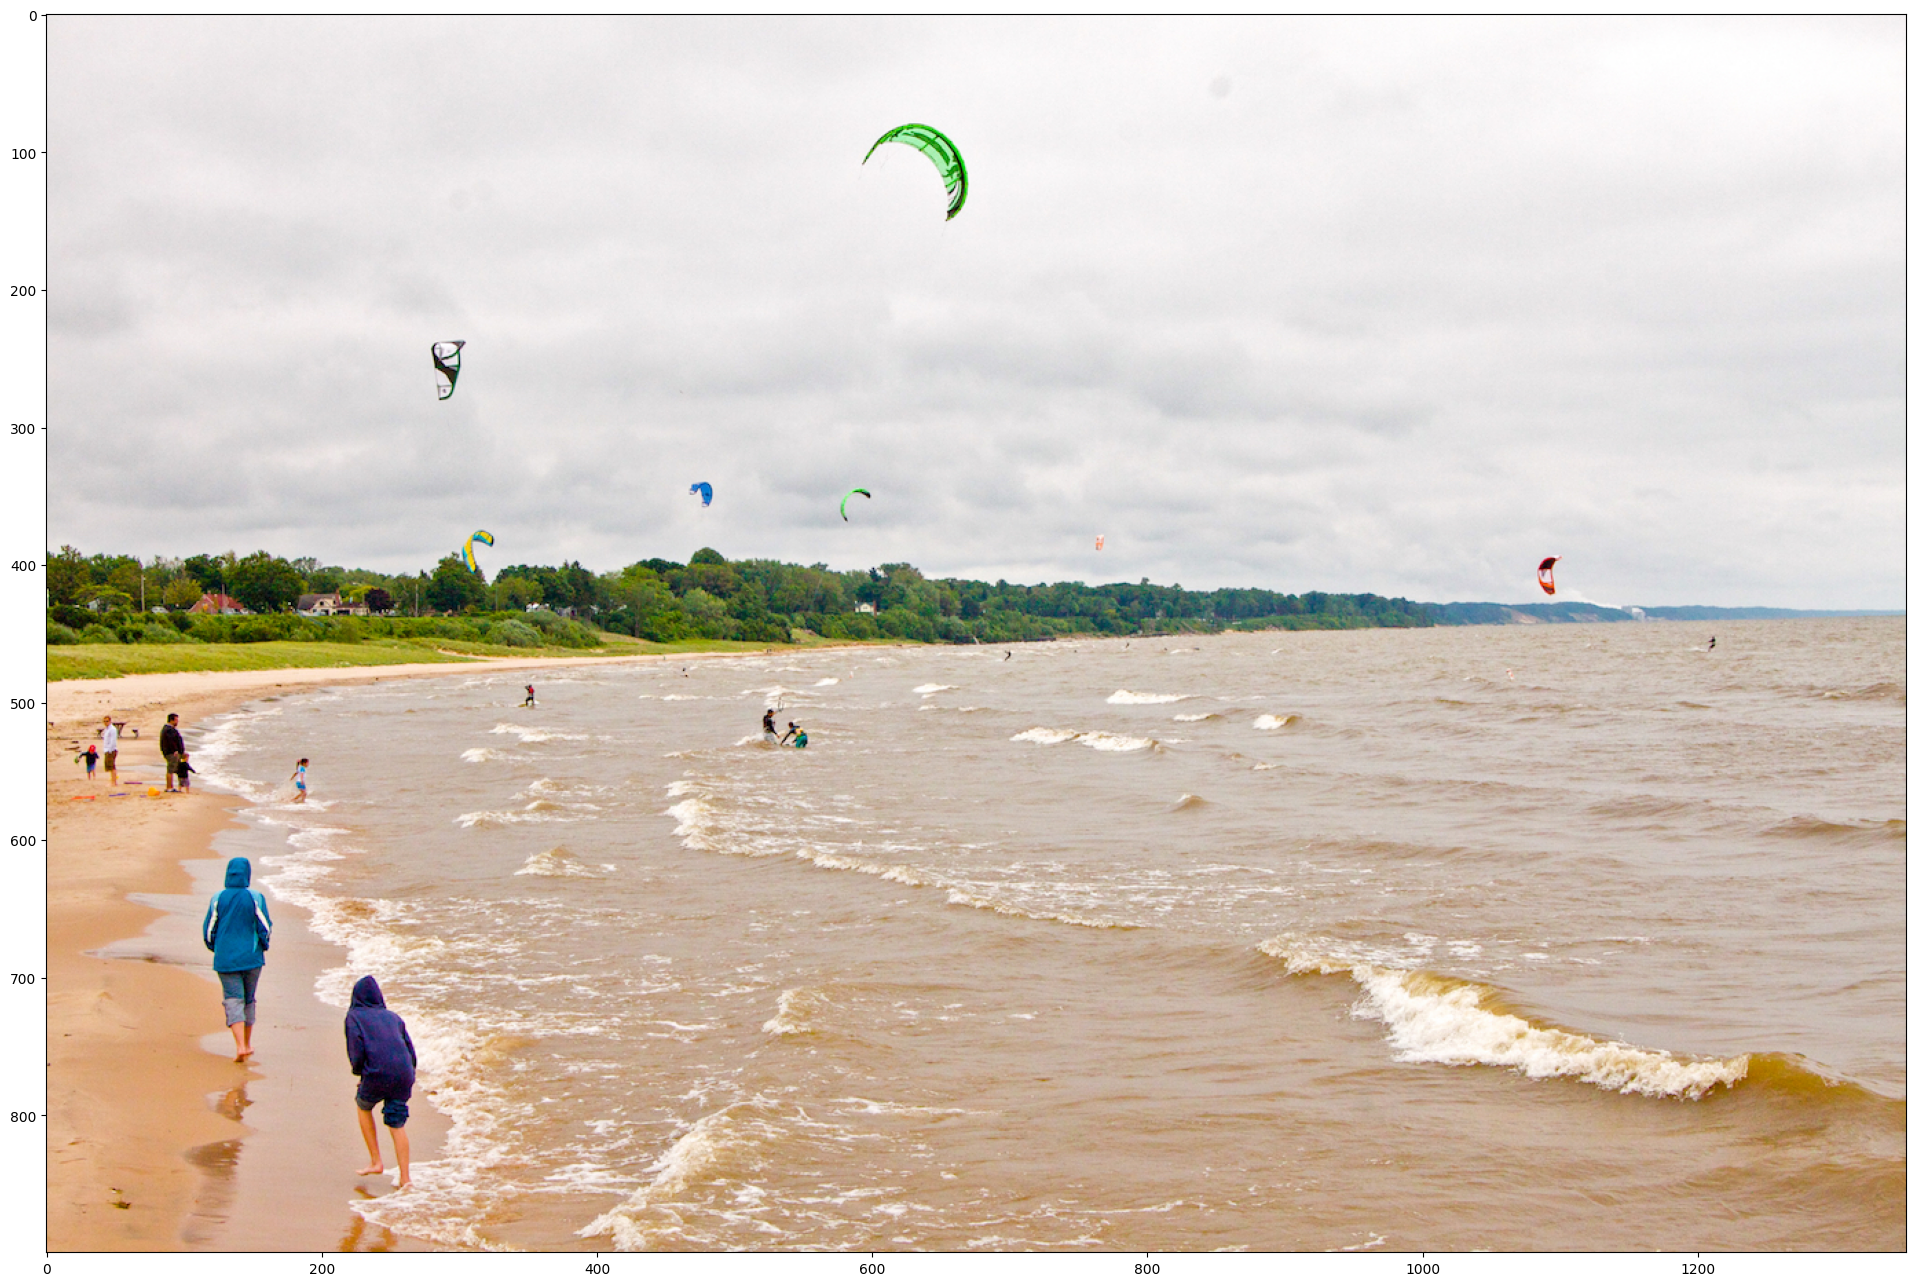

In [11]:
#@title Image Selection (don't forget to execute the cell!) { display-mode: "form"}
selected_image = 'Beach' # @param ['Beach', 'Dogs', 'Naxos Taverna', 'Beatles', 'Phones', 'Birds']
flip_image_horizontally = False #@param {type:"boolean"}
convert_image_to_grayscale = False #@param {type:"boolean"}

image_path = IMAGES_FOR_TEST[selected_image]
image_np = load_image_into_numpy_array(image_path)
#과제 할 때는 위의 코드 모두 필요 없고, impage_np 변수에 원하는 이미지 넣어야 함, numpy_array 형태로 넣기

# Flip horizontally
if(flip_image_horizontally):
  image_np[0] = np.fliplr(image_np[0]).copy()

# Convert image to grayscale
if(convert_image_to_grayscale):
  image_np[0] = np.tile(
    np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

## 추론하기

추론을 수행하려면 TF Hub 로드 모델을 호출하기만 하면 됩니다.

시도해볼 수 있는 작업:

- `result['detection_boxes']`를 출력하고 상자 위치를 이미지의 상자와 일치시킵니다. 좌표는 정규화된 형식(예: [0, 1] 간격)으로 제공됩니다.
- 결과에 있는 다른 출력 키를 검사합니다. 모델 문서 페이지에서 전체 문서를 볼 수 있습니다(브라우저에서 앞서 출력된 모델 핸들을 가리킴).

In [12]:
# running inference
# hub_model: 위에서 선택한 모델로 불러오도록 코드 구성
# hub_model에서 이미지는 4채널로 선언해주어야 함. 따라서 맨 앞에 1차원 만들어줌
print(image_np.shape)    #이미지 크기 확인
results = hub_model(image_np)

# different object detection models have additional results
# all of them are explained in the documentation
# TF Hub 사용법: 모델의 결과값을 dict 형태로 선언하여 사용
result = {key:value.numpy() for key,value in results.items()}
print(result.keys())    # 실제 값들이 어떻게 구성되어 있는지 보기 위한 출력

(1, 900, 1352, 3)
dict_keys(['raw_detection_boxes', 'num_detections', 'detection_classes', 'raw_detection_scores', 'detection_anchor_indices', 'detection_boxes', 'detection_multiclass_scores', 'detection_scores'])


## 결과 시각화하기

여기에서는 추론 단계의 사각형(및 가능한 경우 키포인트)을 표시하기 위해 TensorFlow Object Detection API가 필요합니다.

이 방법을 보여주는 전체 문서는 [여기](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py)에서 확인할 수 있습니다.

예를 들어, 여기에서 `min_score_thresh`를 다른 값(0과 1 사이)으로 설정하여 더 많이 감지할 수 있게 하거나 더 많은 감지를 필터링할 수 있습니다.

In [13]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in result:
  keypoints = result['detection_keypoints'][0]
  keypoint_scores = result['detection_keypoint_scores'][0]

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
              # 함수 내부에서 원본 이미지의 크기 확인 및 화면에 그리는 이미지 선언
              # 모델 종류에 상관없이 이미지 크기는 원본 그대로 넣어도 된다.
              # 자동으로 /255 계산과, resize 코드가 내장되어 있다.
              # 원본 이미지값을 사용해야 나중에 화면에 표시할때 원본 크기로 계산할때 필요하기 때문
      result['detection_boxes'][0],                                   # 사각형 좌표 들
      (result['detection_classes'][0] + label_id_offset).astype(int), # Class 종류
      result['detection_scores'][0],                                  # 각 사각형에 대한 object인 확률 (0~1 사이)
      category_index,                                                 # category 종류를 넣어주면 출력한 class 숫자를 category_index[class]로 출력해준다.
      use_normalized_coordinates=True,                                # max_boxes_to_draw와 min_score_thresh 사용여부
      max_boxes_to_draw=200,                                          # 최대 200개까지 그림
      min_score_thresh=.30,                                           # score값이 0.3이하면 제거
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)


plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()

#### OpenCV로 비디오 영상 읽기 쓰기 연습
* 본 예제는 https://github.com/chulminkw/DLCV 에서 코드를 다운받아 수정된 코드임


#### OpenCV 비디오 영상처리
* OpenCV는 간편하게 비디오 영상처리를 할 수 있는 API를 제공
* VideoCapture 객체는 Video Streaming을 Frame 별로 Capture하여 처리할 수 있는 기능 제공
* VideoWriter 객체는 VideoCapture로 읽어들인 Frame을 동영상으로 Write하는 기능 제공

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
!ls "/content/drive/My Drive/Colab Notebooks"

 faster_r_cnn_bh.ipynb
 faster_r_cnn.ipynb
 object_detection_YOLOv3.ipynb
'object_detection_YOLOv3.ipynb의 사본'
 tf_hub_classification_bh.ipynb
 tf_hub_classification.ipynb
 tf_object_detection_faster_rcnn.ipynb
'tf_object_detection_faster_rcnn.ipynb의 사본'
'과제1_Image_Classification_K2023021_박보현 (1).ipynb'
 과제1_Image_Classification_K2023021_박보현.ipynb
'[소프트웨어융합대학원2023_2] 인공지능수학_과제1_박보현 (1).ipynb'
'[소프트웨어융합대학원2023_2] 인공지능수학_과제1_박보현.ipynb'
'[소프트웨어융합대학원2023_2] 인공지능수학_과제2_박보현.ipynb'
'[소프트웨어융합대학원2023_2] 인공지능수학_과제3.ipynb의 사본'
'[소프트웨어융합대학원2023_2] 인공지능수학_과제3_박보현.ipynb'
'[소프트웨어융합대학원2023_2]_인공지능수학_중간고사_박보현 (1).ipynb'
'[소프트웨어융합대학원2023_2] 인공지능수학_중간고사_박보현.ipynb'


In [ ]:
# 아래 imoprt cv2 셀 실행 시, 에러 발생하면, opencv 버전 문제일 수 있음. 최신버전 uninstall 후 새로 설치
pip uninstall opencv-python-headless==4.5.5.62

In [ ]:
pip install opencv-python-headless==4.5.2.52

In [18]:
import cv2

video_input_path = "/content/drive/MyDrive/Colab Notebooks/balloon_dog01.mp4"
# linux에서 video output의 확장자는 반드시 avi 로 설정 필요.
video_output_path = "/content/drive/MyDrive/Colab Notebooks/balloon_dog01_result.avi"

# 동영상 불러오기
cap = cv2.VideoCapture(video_input_path)

# avi 코덱 선언
codec = cv2.VideoWriter_fourcc(*'XVID')
# 동영상 이미지 가로 크기
width = round(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# 동영상 이미지 세로 크기
height = round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
# 동영상 초당 영상 재생 개수
vid_fps = cap.get(cv2.CAP_PROP_FPS)
# 동영상 저장용 선언
vid_writer = cv2.VideoWriter(video_output_path, codec, vid_fps, vid_size)

# 동영상 총 이미지 갯수=총 frame 갯수
frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('총 Frame 갯수:', frame_cnt)
print('fps:',vid_fps)
print('총 시간:', int(frame_cnt/vid_fps),'초 = ', int(frame_cnt/vid_fps/60),'분', int(frame_cnt/vid_fps)%60,'초')
print('가로:', width, '세로:', height)

# 동영상에서 불필요한 장면을 스킵 하기 위해서 비디오 시작지점을 설정한다.
# cap.set(cv2.CAP_PROP_POS_FRAMES, 40*vid_fps)

총 Frame 갯수: 314
fps: 30.0
총 시간: 10 초 =  0 분 10 초
가로: 544 세로: 676


In [19]:
import time

In [20]:
def get_hub_model_result(image, _model):
  # _model은 위에서 선택한 모델로 불러오도록 코드를 구성
  # 선택한 모델로 찾을 image와 box와 labeling할 이미지
  start = time.time()
  results = _model(image)
  end = time.time()
  print(end-start)

  # different object detection models have additional results
  # all of them are explained in the documentation
  # tensorflow hub의 사용법은 모델의 결과값을 dict형태로 선언해서 사용하기 때문에 아래 형태로 선언
  result = {key:value.numpy() for key,value in results.items()}
  # 시작이 1 인지 0 인지 차이를 선언
  label_id_offset = 0

  viz_utils.visualize_boxes_and_labels_on_image_array(
      image[0],  # 함수 내부에서 원본 이미지의 크기 확인 및 화면에 그리는 이미지 선언
                 # 모델 종류에 상관없이 이미지 크기는 원본 그대로 넣어도 된다.
                 # 자동으로 /255 계산과, resize 코드가 내장되어 있다.
                 # 원본 이미지값을 사용해야 나중에 화면에 표시할때 원본 크기로 계산할때 필요하기 때문
      result['detection_boxes'][0],  # 사각형 좌표 들
      (result['detection_classes'][0] + label_id_offset).astype(int),  # class 종류
      result['detection_scores'][0],  # 각 사각형에 대한 object인 확률 (0~1 사이)
      category_index,  # category 종류를 넣어주면 출력한 class 숫자를 category_index[class]로 출력해준다.
      use_normalized_coordinates=True, # max_boxes_to_draw와 min_score_thresh 사용여부
      max_boxes_to_draw=200,  # 최대 200개 까지 그린다.
      min_score_thresh=.30,  # score값이 0.3 이하는 제거
      agnostic_mode=False,  # True일 경우 score만 표시, clas 표시 안함, 기본은 False
      # 아래는 해당 값이 있으면 사용함
   )
  return image[0]

In [22]:
frame_count = 0
while True:
  hasFrame, img_frame = cap.read()
  print('frame count', frame_count)
  if not hasFrame:
    print('더 이상 처리할 frame이 없습니다.')
    break

  # hub_model에서는 이미지는 4체널로 선언해줘야 하기 때문에 앞에 1차원을 만들어줌
  test_img = np.array(img_frame).reshape((1, height, width, 3)).astype(np.uint8)
  # test_img : 테스트할 이미지, hub_model : 테스트할 모델
  draw_img_frame  = get_hub_model_result(test_img, hub_model)
  # 동영상중에서 1개의 frame 이미지를 진행했다는 count 표시용
  frame_count += 1

  # 아래는 확인용 코드
  # plt.figure(figsize=(24,32))  # 크게 보고싶으면 코드 주석 제거
  # plt.imshow(draw_img_frame)
  # plt.show()
  vid_writer.write(draw_img_frame)

  # 너무 많이 저장하면 오래걸리기 때문에 짧은 시간안에 테스트 할정도로 설정
  if frame_count > 20: break

vid_writer.release()
cap.release()

frame count 0
7.7147216796875
frame count 1
6.635402202606201
frame count 2
4.622611045837402
frame count 3
5.567715167999268
frame count 4
7.712056398391724
frame count 5
6.0029520988464355
frame count 6
6.759783983230591
frame count 7
8.561302900314331
frame count 8
7.88340950012207
frame count 9
5.215163946151733
frame count 10
4.704484462738037
frame count 11
6.34646201133728
frame count 12
7.9607932567596436
frame count 13
4.857367038726807
frame count 14
4.489387273788452
frame count 15
6.544121742248535
frame count 16
7.556159496307373
frame count 17
4.8658833503723145
frame count 18
4.948175668716431
frame count 19
7.495720386505127
frame count 20
7.136634349822998
